In [105]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [79]:
data16 = pd.read_excel('./Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xls')
data16

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,63391,1568.4050,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.1870,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.5380,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.2610,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.5240,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,85983,1157.1160,444.3447,248.8627,0.8284,330.8730,0.9823,87536,0.6799,1.7855,0.8070,0.7446,0.0052,0.0029,0.5545,0.9900,Siit_Pistachio
2144,85691,2327.3459,439.8794,278.9297,0.7732,330.3107,0.8886,96439,0.6590,1.5770,0.1988,0.7509,0.0051,0.0033,0.5639,0.8892,Siit_Pistachio
2145,101136,1255.6190,475.2161,271.3299,0.8210,358.8459,0.9888,102286,0.7584,1.7514,0.8061,0.7551,0.0047,0.0027,0.5702,0.9987,Siit_Pistachio
2146,97409,1195.2150,452.1823,274.5764,0.7945,352.1718,0.9902,98376,0.7635,1.6468,0.8569,0.7788,0.0046,0.0028,0.6066,0.9989,Siit_Pistachio


In [120]:
labels = ['Kirmizi_Pistachio', 'Siit_Pistachio']
one_hot_encode = lambda x: 0 if x == 'Kirmizi_Pistachio' else 1
one_hot_encode_revert = lambda x: labels[x]

In [80]:
X = data16.drop('Class', axis=1)
y = data16['Class']
y = y.apply(one_hot_encode)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

In [81]:
scaler = StandardScaler()
pca = PCA()
# label = LabelEncoder()
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

## Grid Search

In [82]:
params = {
    'pca__n_components': [5, 10, 15, X.shape[1]],
    'knn__n_neighbors': np.arange(1, 21),
    'knn__metric': ['euclidean', 'minkowski', 'manhattan'],
    # 'knn__metric': ['euclidean', 'minkowski', 'manhattan', 'mahalanobis']
}
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
grid = GridSearchCV(pipe, params, cv=10, scoring=scoring, refit='accuracy', return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'minkowski', 'manhattan'],
                         'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'pca__n_components': [5, 10, 15, 16]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [83]:
grid.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 13, 'pca__n_components': 15}

In [109]:
grid.cv_results_["param_pca__n_components"]

masked_array(data=[5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15,
                   16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10,
                   15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5,
                   10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15,
                   16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10,
                   15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5,
                   10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15,
                   16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10,
                   15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5,
                   10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15,
                   16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10,
                   15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5,
                   10, 15, 16, 5, 10, 15, 16, 5, 10, 15, 16, 5, 10, 15,
                   16, 5, 10, 15, 16,

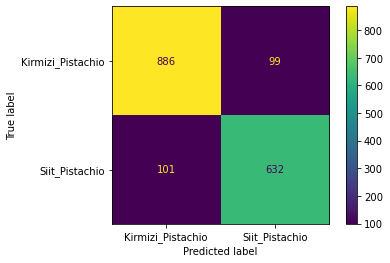

In [122]:
plot_confusion_matrix(grid, X_train, y_train, display_labels=labels)  
plt.show()

## Test

In [123]:
grid.classes_

array([0, 1], dtype=int64)

---- 16-feature dataset test results
{'knn__metric': 'manhattan', 'knn__n_neighbors': 13, 'pca__n_components': 15}
accuracy: 0.8767441860465116
f1_score: 0.8515406162464986
precision: 0.8735632183908046
recall: 0.8306010928961749


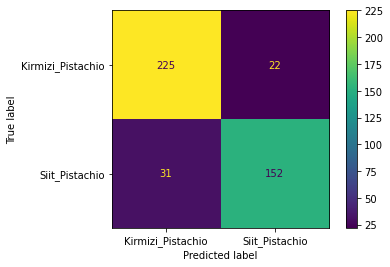

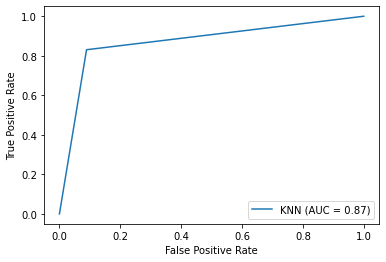

In [124]:
y_pred = grid.predict(X_test)

print("---- 16-feature dataset test results")
print(grid.best_params_)
print("accuracy:", accuracy_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='KNN')
display.plot()
plt.show()